In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import mlflow
import mlflow.pytorch
import os

c:\Users\devil\anaconda3\envs\airParadis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Vérifier si un GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entraînement sur : {device}")

Entraînement sur : cpu


In [4]:
# Chargement des données
data = pd.read_csv("data/train_df.csv")
data = data.dropna(subset=['words'])

In [5]:
# Tokenisation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len = 128

In [6]:
def encode_text(texts, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [7]:
input_ids, attention_masks = encode_text(data['words'], tokenizer, max_len)
labels = torch.tensor(data['target'].values)

c:\Users\devil\anaconda3\envs\airParadis\Lib\site-packages\transformers\tokenization_utils_base.py:2673: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
# Division des données
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42
)
train_masks, validation_masks = train_test_split(attention_masks, test_size=0.2, random_state=42)
def to_torch_tensor(*args):
    return [torch.tensor(arg) for arg in args]

train_inputs, validation_inputs, train_masks, validation_masks = to_torch_tensor(
    train_inputs, validation_inputs, train_masks, validation_masks
)


C:\Users\devil\AppData\Local\Temp\ipykernel_28220\3572572109.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return [torch.tensor(arg) for arg in args]


In [9]:
# Charger le modèle
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from torch.utils.data import Dataset

class BERTDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels=None):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx]
        }
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

# Créer les datasets
train_dataset = BERTDataset(train_inputs, train_masks, train_labels)
validation_dataset = BERTDataset(validation_inputs, validation_masks, validation_labels)

c:\Users\devil\anaconda3\envs\airParadis\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  6%|▋         | 10/160 [05:57<1:25:27, 34.19s/it]

{'loss': 0.5054, 'grad_norm': 3.7356209754943848, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.06}


 12%|█▎        | 20/160 [11:38<1:18:37, 33.70s/it]

{'loss': 0.4982, 'grad_norm': 4.050662040710449, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.12}


 19%|█▉        | 30/160 [17:14<1:12:51, 33.63s/it]

{'loss': 0.5008, 'grad_norm': 3.6316213607788086, 'learning_rate': 3e-06, 'epoch': 0.19}


 25%|██▌       | 40/160 [22:51<1:07:24, 33.71s/it]

{'loss': 0.5333, 'grad_norm': 4.892152309417725, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.25}


 31%|███▏      | 50/160 [28:28<1:01:42, 33.66s/it]

{'loss': 0.4665, 'grad_norm': 3.97091007232666, 'learning_rate': 5e-06, 'epoch': 0.31}


 38%|███▊      | 60/160 [34:05<55:56, 33.57s/it]  

{'loss': 0.4769, 'grad_norm': 3.5285379886627197, 'learning_rate': 6e-06, 'epoch': 0.38}


 44%|████▍     | 70/160 [39:38<50:01, 33.35s/it]

{'loss': 0.4969, 'grad_norm': 4.489910125732422, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.44}


 50%|█████     | 80/160 [45:16<45:11, 33.89s/it]

{'loss': 0.4296, 'grad_norm': 4.070300579071045, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.5}


 56%|█████▋    | 90/160 [50:55<39:50, 34.16s/it]

{'loss': 0.4332, 'grad_norm': 5.145999431610107, 'learning_rate': 9e-06, 'epoch': 0.56}


 62%|██████▎   | 100/160 [56:33<33:39, 33.65s/it]

{'loss': 0.3932, 'grad_norm': 3.6836018562316895, 'learning_rate': 1e-05, 'epoch': 0.62}


 69%|██████▉   | 110/160 [1:02:08<27:52, 33.46s/it]

{'loss': 0.3242, 'grad_norm': 4.142594337463379, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.69}


 75%|███████▌  | 120/160 [1:07:54<22:46, 34.17s/it]

{'loss': 0.321, 'grad_norm': 4.978655815124512, 'learning_rate': 1.2e-05, 'epoch': 0.75}


 81%|████████▏ | 130/160 [1:13:30<16:43, 33.46s/it]

{'loss': 0.3599, 'grad_norm': 4.547299861907959, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.81}


 88%|████████▊ | 140/160 [1:19:08<11:14, 33.74s/it]

{'loss': 0.3421, 'grad_norm': 4.844790458679199, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.88}


 94%|█████████▍| 150/160 [1:24:44<05:36, 33.69s/it]

{'loss': 0.3077, 'grad_norm': 4.997217178344727, 'learning_rate': 1.5e-05, 'epoch': 0.94}


100%|██████████| 160/160 [1:30:21<00:00, 33.63s/it]

{'loss': 0.4264, 'grad_norm': 9.974105834960938, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}



100%|██████████| 160/160 [1:37:07<00:00, 33.63s/it]

{'eval_loss': 0.5911170244216919, 'eval_accuracy': 0.753125, 'eval_roc_auc': 0.8306379893048911, 'eval_runtime': 403.093, 'eval_samples_per_second': 6.351, 'eval_steps_per_second': 0.099, 'epoch': 1.0}


100%|██████████| 160/160 [1:37:10<00:00, 36.44s/it]


{'train_runtime': 5830.5656, 'train_samples_per_second': 1.756, 'train_steps_per_second': 0.027, 'train_loss': 0.42595899701118467, 'epoch': 1.0}


100%|██████████| 40/40 [06:31<00:00,  9.80s/it]


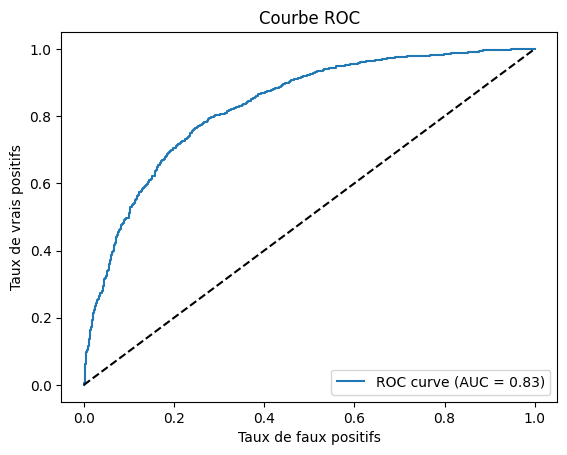

2025/01/17 13:57:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [12]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SequentialSampler

# Initialisation de MLflow
mlflow.set_experiment("text_classification_experiment")
with mlflow.start_run():
    mlflow.set_tag("model_type", "BERT-base")

    # Entraînement
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1, 
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True
    )

    def compute_metrics(eval_preds):
        logits, labels = eval_preds
        preds = np.argmax(logits, axis=1)
        accuracy = (preds == labels).mean()
        roc_auc = roc_auc_score(labels, logits[:, 1])
        return {"accuracy": accuracy, "roc_auc": roc_auc}

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=validation_dataset,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # Évaluation
    results = trainer.evaluate()
    mlflow.log_metrics(results)

    # ROC Curve
    logits = trainer.predict(validation_dataset).predictions

    fpr, tpr, _ = roc_curve(validation_labels.numpy(), logits[:, 1])
    roc_auc = roc_auc_score(validation_labels.numpy(), logits[:, 1])

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
    plt.title("Courbe ROC")
    plt.legend(loc="lower right")
    plt.show()

    # Enregistrement des métriques supplémentaires
    mlflow.log_metric("roc_auc", roc_auc)

    # Enregistrement du modèle
    mlflow.pytorch.log_model(model, "bert_model")